In [30]:
import sys
!{sys.executable} -m pip install imbalanced-learn
import sys
!{sys.executable} -m pip install geopy


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: /opt/homebrew/opt/python@3.10/bin/python3.10 -m pip install --upgrade pip
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [geopy]

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: /opt/homebrew/opt/python@3.10/bin/python3.10 -m pip install --upgrade pip


In [22]:
# Basic packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ML & DL packages
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

from imblearn.over_sampling import SMOTE

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


In [26]:
# Load dataset
df = pd.read_csv("/Users/jerry/Desktop/Personal Project/Credit Risk/credit_card_transactions.csv")

# Show shape and first rows
print("Dataset shape:", df.shape)
df.head()


Dataset shape: (1296675, 24)


,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,merch_zipcode
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,28705.0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,NaN
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,83236.0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,NaN
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,22844.0


,Missing Values,Missing Ratio (%)
merch_zipcode,195973,15.11
trans_date_trans_time,0,0.00
is_fraud,0,0.00
merch_long,0,0.00
merch_lat,0,0.00
unix_time,0,0.00
trans_num,0,0.00
dob,0,0.00
job,0,0.00
city_pop,0,0.00


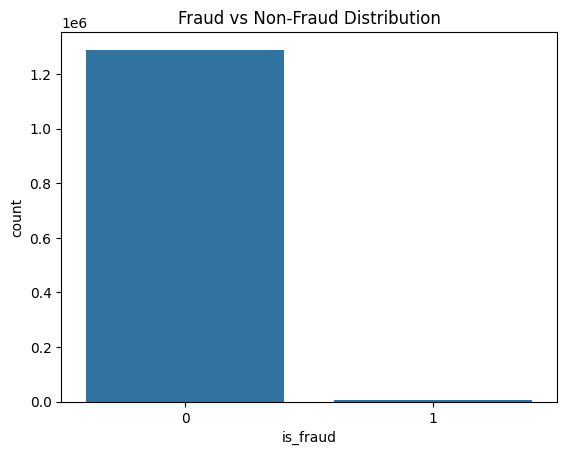

In [27]:
# Missing values
missing_df = df.isnull().sum().to_frame("Missing Values")
missing_df["Missing Ratio (%)"] = (df.isnull().sum() / len(df) * 100).round(2)
display(missing_df.sort_values("Missing Ratio (%)", ascending=False))

# Target variable distribution
sns.countplot(x="is_fraud", data=df)
plt.title("Fraud vs Non-Fraud Distribution")
plt.show()


Remaining rows after dropna: 1100702
Remaining columns: 24

Fraud distribution (after removing nulls):
is_fraud
0    1094339
1       6363
Name: count, dtype: int64

Fraud ratio (%):
is_fraud
0    99.42
1     0.58
Name: count, dtype: float64


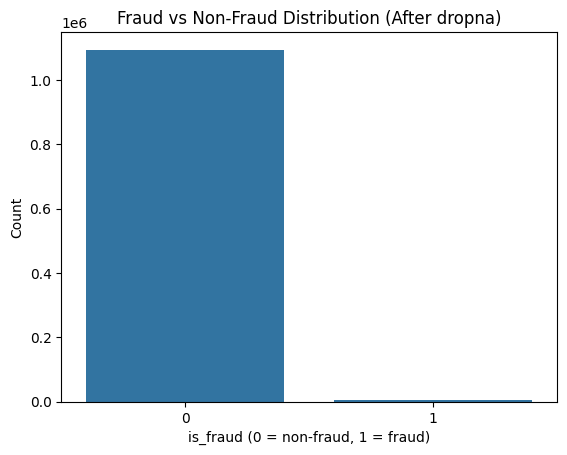

In [28]:
# ===============================
# Remove rows with null values
# ===============================
df = df.dropna()

print("Remaining rows after dropna:", df.shape[0])
print("Remaining columns:", df.shape[1])

# ===============================
# Fraud distribution after cleaning
# ===============================
fraud_counts = df["is_fraud"].value_counts()
fraud_ratio = (fraud_counts / len(df) * 100).round(2)

print("\nFraud distribution (after removing nulls):")
print(fraud_counts)
print("\nFraud ratio (%):")
print(fraud_ratio)

# ===============================
# Plot fraud vs non-fraud
# ===============================
sns.countplot(x="is_fraud", data=df)
plt.title("Fraud vs Non-Fraud Distribution (After dropna)")
plt.xlabel("is_fraud (0 = non-fraud, 1 = fraud)")
plt.ylabel("Count")
plt.show()


In [31]:

from geopy.distance import geodesic
from sklearn.preprocessing import LabelEncoder

# --- Time-based features ---
df["trans_date"] = pd.to_datetime(df["unix_time"], unit="s")
df["hour"] = df["trans_date"].dt.hour
df["dayofweek"] = df["trans_date"].dt.dayofweek

In [32]:
# --- Distance between customer and merchant ---
df["distance"] = df.apply(
    lambda row: geodesic((row["lat"], row["long"]), (row["merch_lat"], row["merch_long"])).km,
    axis=1
)


In [33]:
# --- Encode categorical variables ---
cat_cols = ["category", "gender", "state", "job"]
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))

print("Feature engineering done. Current shape:", df.shape)

Feature engineering done. Current shape: (1100702, 28)


In [37]:
# Define feature matrix (X) and target (y)
X = df.drop(columns=[
    "is_fraud",               # target column
    "trans_date_trans_time",  # raw datetime
    "dob",                    # replaced by age
    "merchant", "first", "last", "street", "city", "trans_num"  # IDs / text
]).select_dtypes(include=[np.number])  # keep only numeric columns

y = df["is_fraud"]

print("Final feature matrix shape:", X.shape)
print("Target distribution:\n", y.value_counts())
print("Remaining non-numeric columns:", X.select_dtypes(exclude=[np.number]).columns.tolist())


Final feature matrix shape: (1100702, 18)
Target distribution:
 is_fraud
0    1094339
1       6363
Name: count, dtype: int64
Remaining non-numeric columns: []


In [38]:
# Show all non-numeric columns
non_numeric_cols = X.select_dtypes(exclude=[np.number]).columns
print("Non-numeric columns:", non_numeric_cols.tolist())


Non-numeric columns: []


In [40]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# ===============================
# Train-Test Split
# ===============================
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y   # keep same fraud ratio in train/test
)

print("Train set size:", X_train.shape)
print("Test set size:", X_test.shape)

# ===============================
# Fraud ratio BEFORE SMOTE
# ===============================
print("\nFraud distribution in training set (BEFORE SMOTE):")
print(y_train.value_counts())
print((y_train.value_counts(normalize=True) * 100).round(2))

# ===============================
# Apply SMOTE
# ===============================
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# ===============================
# Fraud ratio AFTER SMOTE
# ===============================
print("\nFraud distribution in training set (AFTER SMOTE):")
print(y_train_res.value_counts())
print((y_train_res.value_counts(normalize=True) * 100).round(2))


Train set size: (770491, 18)
Test set size: (330211, 18)

Fraud distribution in training set (BEFORE SMOTE):
is_fraud
0    766037
1      4454
Name: count, dtype: int64
is_fraud
0    99.42
1     0.58
Name: proportion, dtype: float64

Fraud distribution in training set (AFTER SMOTE):
is_fraud
0    766037
1    766037
Name: count, dtype: int64
is_fraud
0    50.0
1    50.0
Name: proportion, dtype: float64


In [41]:
##Logistic Regression (Baseline)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

# Train Logistic Regression
lr = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)
lr.fit(X_train_res, y_train_res)

# Predict
y_pred_lr = lr.predict(X_test)
y_prob_lr = lr.predict_proba(X_test)[:, 1]

# Evaluation
print("=== Logistic Regression ===")
print(classification_report(y_test, y_pred_lr, digits=4))
print("AUC:", roc_auc_score(y_test, y_prob_lr))


=== Logistic Regression ===


/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


              precision    recall  f1-score   support

           0     0.9942    1.0000    0.9971    328302
           1     0.0000    0.0000    0.0000      1909

    accuracy                         0.9942    330211
   macro avg     0.4971    0.5000    0.4986    330211
weighted avg     0.9885    0.9942    0.9913    330211

AUC: 0.4967933946800232


In [42]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob_lr)

# Choose a lower threshold, e.g., 0.2
y_pred_lr_adjusted = (y_prob_lr > 0.2).astype(int)
print(classification_report(y_test, y_pred_lr_adjusted, digits=4))


              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000    328302
           1     0.0058    1.0000    0.0115      1909

    accuracy                         0.0058    330211
   macro avg     0.0029    0.5000    0.0057    330211
weighted avg     0.0000    0.0058    0.0001    330211



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


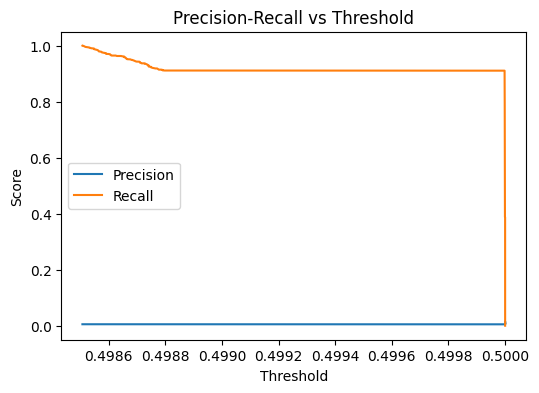

In [43]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob_lr)

plt.figure(figsize=(6,4))
plt.plot(thresholds, precisions[:-1], label="Precision")
plt.plot(thresholds, recalls[:-1], label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision-Recall vs Threshold")
plt.legend()
plt.show()


In [47]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Train Random Forest
rf = RandomForestClassifier(
    n_estimators=150,
    max_depth=20,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced"   # 给 fraud 类更多权重
)
rf.fit(X_train_res, y_train_res)

# Predict
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

# Evaluation
print("=== Random Forest ===")
print(classification_report(y_test, y_pred_rf, digits=4))
print("AUC:", roc_auc_score(y_test, y_prob_rf))


=== Random Forest ===
              precision    recall  f1-score   support

           0     0.9990    0.9886    0.9937    328302
           1     0.2954    0.8250    0.4350      1909

    accuracy                         0.9876    330211
   macro avg     0.6472    0.9068    0.7144    330211
weighted avg     0.9949    0.9876    0.9905    330211

AUC: 0.9777223668637973


In [48]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Get precision, recall, thresholds
precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob_rf)

# Average Precision (AP) score, 类似于 PR AUC
ap_score = average_precision_score(y_test, y_prob_rf)
print("Average Precision Score (AP):", round(ap_score, 4))


Average Precision Score (AP): 0.6509


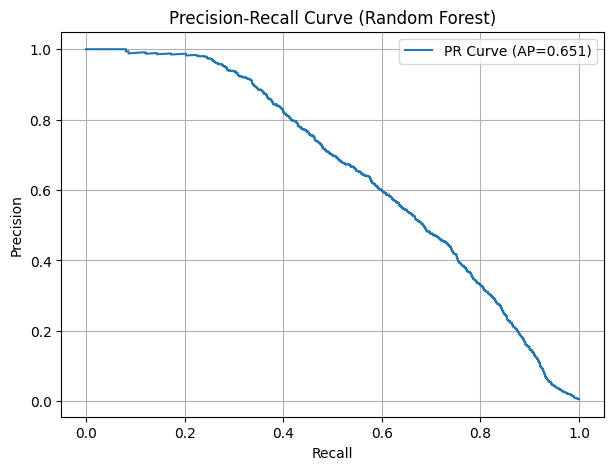

In [49]:
plt.figure(figsize=(7,5))
plt.plot(recalls, precisions, label=f"PR Curve (AP={ap_score:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Random Forest)")
plt.legend()
plt.grid(True)
plt.show()


In [50]:
import numpy as np

# 找到第一个同时满足 Recall >= 0.7 且 Precision >= 0.3 的阈值
idx = np.where((recalls >= 0.7) & (precisions >= 0.3))[0][0]
best_threshold = thresholds[idx]

print(f"Chosen threshold = {best_threshold:.4f}")
print(f"Precision = {precisions[idx]:.3f}, Recall = {recalls[idx]:.3f}")


Chosen threshold = 0.5082
Precision = 0.300, Recall = 0.821


In [52]:
y_pred_rf_adjusted = (y_prob_rf >= best_threshold).astype(int)

from sklearn.metrics import classification_report
print("=== Random Forest (Adjusted Threshold) ===")
print(classification_report(y_test, y_pred_rf_adjusted, digits=4))


=== Random Forest (Adjusted Threshold) ===
              precision    recall  f1-score   support

           0     0.9990    0.9889    0.9939    328302
           1     0.3000    0.8214    0.4395      1909

    accuracy                         0.9879    330211
   macro avg     0.6495    0.9051    0.7167    330211
weighted avg     0.9949    0.9879    0.9907    330211



In [53]:
#Prepare categorical & numeric splits for TabTransformer
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model

# Identify categorical and numeric columns from your current X
# (keep only those that actually exist)
candidate_cat = ["category", "gender", "state", "job"]
cat_cols = [c for c in candidate_cat if c in X.columns]
num_cols = [c for c in X.columns if c not in cat_cols]

print("Categorical cols used:", cat_cols)
print("Numeric cols used:", num_cols)

# Safety: ensure integer dtype for categorical indices
X_train_cat = X_train_res[cat_cols].astype("int32").values if cat_cols else None
X_test_cat  = X_test[cat_cols].astype("int32").values if cat_cols else None

# Numeric features as float32
X_train_num = X_train_res[num_cols].astype("float32").values
X_test_num  = X_test[num_cols].astype("float32").values

# Vocab sizes for each categorical column (LabelEncoder produced 0..K-1)
vocab_sizes = [int(X[c].nunique()) for c in cat_cols]
vocab_sizes


Categorical cols used: ['category', 'gender', 'state', 'job']
Numeric cols used: ['Unnamed: 0', 'cc_num', 'amt', 'zip', 'lat', 'long', 'city_pop', 'unix_time', 'merch_lat', 'merch_long', 'merch_zipcode', 'hour', 'dayofweek', 'distance']


[14, 2, 50, 493]

In [54]:
#scale numeric features
from sklearn.preprocessing import StandardScaler

num_scaler = StandardScaler()
X_train_num_scaled = num_scaler.fit_transform(X_train_num)
X_test_num_scaled  = num_scaler.transform(X_test_num)


In [56]:
#Build a lightweight TabTransformer in Keras
# A small Transformer encoder block
class TransformerBlock(layers.Layer):
    def __init__(self, d_model=32, num_heads=4, mlp_ratio=2, dropout=0.1, **kwargs):
        super().__init__(**kwargs)
        self.mha = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model//num_heads, dropout=dropout)
        self.dropout1 = layers.Dropout(dropout)
        self.norm1 = layers.LayerNormalization(epsilon=1e-6)

        self.ffn = tf.keras.Sequential([
            layers.Dense(d_model * mlp_ratio, activation="gelu"),
            layers.Dropout(dropout),
            layers.Dense(d_model)
        ])
        self.dropout2 = layers.Dropout(dropout)
        self.norm2 = layers.LayerNormalization(epsilon=1e-6)

    def call(self, x, training=False):
        attn_out = self.mha(x, x, training=training)
        x = self.norm1(x + self.dropout1(attn_out, training=training))
        ffn_out = self.ffn(x, training=training)
        x = self.norm2(x + self.dropout2(ffn_out, training=training))
        return x

def build_tabtransformer(vocab_sizes, n_num, d_model=32, num_heads=4, n_blocks=2, dropout=0.1):
    """
    vocab_sizes: list of ints, vocab size for each categorical column
    n_num: number of numeric features
    """
    inputs = []
    cat_tokens = []
    # Categorical inputs -> embeddings -> tokens
    for i, vs in enumerate(vocab_sizes):
        inp = layers.Input(shape=(), dtype="int32", name=f"cat_{i}")
        emb_dim = min(32, max(8, int(np.ceil(vs ** 0.25) * 4)))  # a simple rule-of-thumb
        emb = layers.Embedding(input_dim=vs, output_dim=d_model, name=f"emb_{i}")(inp)
        # expand to token dimension (batch, 1, d_model)
        tok = layers.Reshape((1, d_model))(emb)
        inputs.append(inp)
        cat_tokens.append(tok)

    if len(cat_tokens) > 0:
        x_cat = layers.Concatenate(axis=1)(cat_tokens)  # (batch, n_cat, d_model)
        # Optional: add trainable column embeddings
        col_emb = self_col_emb = tf.Variable(
            tf.random.normal([x_cat.shape[1], d_model]), trainable=True, name="col_emb"
        )
        # Add column embeddings
        x_cat = x_cat + col_emb

        # Transformer encoder blocks
        for _ in range(n_blocks):
            x_cat = TransformerBlock(d_model=d_model, num_heads=num_heads, dropout=dropout)(x_cat)

        # Pooling over tokens
        x_cat = layers.GlobalAveragePooling1D()(x_cat)
    else:
        x_cat = None

    # Numeric branch
    num_inp = layers.Input(shape=(n_num,), dtype="float32", name="num_inp")
    inputs.append(num_inp)
    x_num = layers.Dense(d_model, activation="relu")(num_inp)

    # Fuse categorical & numeric
    if x_cat is not None:
        h = layers.Concatenate()([x_cat, x_num])
    else:
        h = x_num

    h = layers.Dropout(dropout)(h)
    h = layers.Dense(64, activation="relu")(h)
    h = layers.Dropout(dropout)(h)
    out = layers.Dense(1, activation="sigmoid")(h)

    model = Model(inputs=inputs, outputs=out)
    return model


In [59]:
# --- compile with PR AUC as the primary metric ---
auc_pr = tf.keras.metrics.AUC(name="auc_pr", curve="PR")   # PR AUC (better for imbalance)
auc_roc = tf.keras.metrics.AUC(name="auc")                 # optional: ROC AUC (reference)
prec_at_rec70 = tf.keras.metrics.PrecisionAtRecall(0.70, name="prec_at_rec70")  # P@R>=0.70
rec_at_prec30 = tf.keras.metrics.RecallAtPrecision(0.30, name="rec_at_prec30") # R@P>=0.30

tabtr.compile(
    optimizer="adam",
    loss="binary_crossentropy",   # or focal_loss()
    metrics=[auc_pr, auc_roc, prec_at_rec70, rec_at_prec30]
)

# --- early stopping monitors PR AUC instead of accuracy/recall ---
early = EarlyStopping(
    monitor="val_auc_pr",
    mode="max",
    patience=3,
    restore_best_weights=True
)

history = tabtr.fit(
    pack_inputs(X_train_cat, X_train_num_scaled),
    y_train_res.values,
    validation_split=0.2,
    epochs=12,
    batch_size=1024,
    callbacks=[early],
    verbose=1
)


Epoch 1/12
1197/1197 ━━━━━━━━━━━━━━━━━━━━ 59s 45ms/step - auc: 0.9760 - auc_pr: 0.9679 - loss: 0.1805 - prec_at_rec70: 0.9912 - rec_at_prec30: 1.0000 - val_auc: 0.0000e+00 - val_auc_pr: 1.0000 - val_loss: 0.1897 - val_prec_at_rec70: 1.0000 - val_rec_at_prec30: 1.0000
Epoch 2/12
1197/1197 ━━━━━━━━━━━━━━━━━━━━ 52s 43ms/step - auc: 0.9835 - auc_pr: 0.9770 - loss: 0.1510 - prec_at_rec70: 0.9947 - rec_at_prec30: 1.0000 - val_auc: 0.0000e+00 - val_auc_pr: 1.0000 - val_loss: 0.1807 - val_prec_at_rec70: 1.0000 - val_rec_at_prec30: 1.0000
Epoch 3/12
1197/1197 ━━━━━━━━━━━━━━━━━━━━ 52s 44ms/step - auc: 0.9883 - auc_pr: 0.9831 - loss: 0.1283 - prec_at_rec70: 0.9958 - rec_at_prec30: 1.0000 - val_auc: 0.0000e+00 - val_auc_pr: 1.0000 - val_loss: 0.1622 - val_prec_at_rec70: 1.0000 - val_rec_at_prec30: 1.0000
Epoch 4/12
1197/1197 ━━━━━━━━━━━━━━━━━━━━ 52s 44ms/step - auc: 0.9913 - auc_pr: 0.9872 - loss: 0.1104 - prec_at_rec70: 0.9970 - rec_at_prec30: 1.0000 - val_auc: 0.0000e+00 - val_auc_pr: 1.0000 - v

In [62]:
# Generate predicted probabilities for TabTransformer
y_prob_tabtr = tabtr.predict(
    pack_inputs(X_test_cat, X_test_num_scaled),
    batch_size=2048
).ravel()


162/162 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step


In [63]:
from sklearn.metrics import average_precision_score, roc_auc_score

ap = average_precision_score(y_test, y_prob_tabtr)   # PR AUC (AP)
roc = roc_auc_score(y_test, y_prob_tabtr)

print(f"AP (PR AUC): {ap:.4f} | ROC AUC: {roc:.4f}")


AP (PR AUC): 0.6533 | ROC AUC: 0.9485


In [64]:
# Ensure you have: lr, rf, tabtr models; X_test, y_test
# For TabTransformer you also need: pack_inputs, X_test_cat, X_test_num_scaled

probs = {}  # model name -> predicted probabilities on test set

# Logistic Regression
try:
    y_prob_lr = lr.predict_proba(X_test)[:, 1]
    probs["LogReg"] = y_prob_lr
    print("Collected probs: LogReg")
except Exception as e:
    print("Skip LogReg:", e)

# Random Forest
try:
    y_prob_rf = rf.predict_proba(X_test)[:, 1]
    probs["RandomForest"] = y_prob_rf
    print("Collected probs: RandomForest")
except Exception as e:
    print("Skip RandomForest:", e)

# TabTransformer
try:
    y_prob_tabtr = tabtr.predict(pack_inputs(X_test_cat, X_test_num_scaled), batch_size=2048).ravel()
    probs["TabTransformer"] = y_prob_tabtr
    print("Collected probs: TabTransformer")
except Exception as e:
    print("Skip TabTransformer:", e)

assert len(probs) > 0, "No model probabilities collected. Make sure the models are trained."


Collected probs: LogReg
Collected probs: RandomForest
162/162 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step
Collected probs: TabTransformer


In [65]:
from sklearn.metrics import average_precision_score, roc_auc_score
import pandas as pd

rows = []
for name, p in probs.items():
    ap  = average_precision_score(y_test, p)
    roc = roc_auc_score(y_test, p)
    rows.append({"model": name, "AP(PR AUC)": ap, "ROC AUC": roc})

summary = pd.DataFrame(rows).sort_values("AP(PR AUC)", ascending=False)
display(summary)


,model,AP(PR AUC),ROC AUC
2,TabTransformer,0.653341,0.948472
1,RandomForest,0.650876,0.977722
0,LogReg,0.006103,0.496793


In [66]:
import numpy as np
from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix

def choose_threshold(y_true, y_prob, min_recall=0.70, min_precision=0.30):
    """Return threshold that first satisfies both constraints; if none, fallback to max-F1 threshold."""
    prec, rec, th = precision_recall_curve(y_true, y_prob)
    idx = np.where((rec >= min_recall) & (prec >= min_precision))[0]
    if len(idx) > 0:
        tidx = idx[0]
        return th[tidx], float(prec[tidx]), float(rec[tidx]), "constraint"
    # fallback to max F1
    f1 = 2 * (prec * rec) / (prec + rec + 1e-12)
    best = np.nanargmax(f1[:-1])  # thresholds shorter by 1
    return th[best], float(prec[best]), float(rec[best]), "maxF1"

for name, p in probs.items():
    th, P, R, how = choose_threshold(y_test, p, min_recall=0.70, min_precision=0.30)
    y_pred = (p >= th).astype(int)
    print(f"\n=== {name} ===")
    print(f"Chosen threshold = {th:.4f}  ({how});  Precision={P:.3f}, Recall={R:.3f}")
    print(classification_report(y_test, y_pred, digits=4))
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion matrix:\n", cm)



=== LogReg ===
Chosen threshold = 0.5000  (maxF1);  Precision=0.011, Recall=0.032
              precision    recall  f1-score   support

           0     0.9943    0.9838    0.9890    328302
           1     0.0114    0.0320    0.0168      1909

    accuracy                         0.9783    330211
   macro avg     0.5028    0.5079    0.5029    330211
weighted avg     0.9886    0.9783    0.9834    330211

Confusion matrix:
 [[322990   5312]
 [  1848     61]]

=== RandomForest ===
Chosen threshold = 0.5082  (constraint);  Precision=0.300, Recall=0.821
              precision    recall  f1-score   support

           0     0.9990    0.9889    0.9939    328302
           1     0.3000    0.8214    0.4395      1909

    accuracy                         0.9879    330211
   macro avg     0.6495    0.9051    0.7167    330211
weighted avg     0.9949    0.9879    0.9907    330211

Confusion matrix:
 [[324644   3658]
 [   341   1568]]

=== TabTransformer ===
Chosen threshold = 0.7927  (constrain

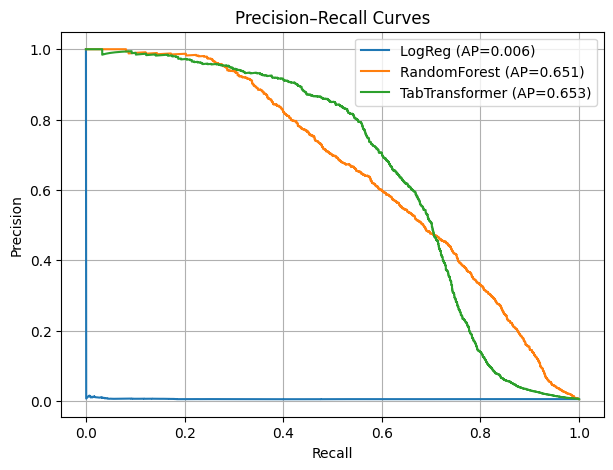

In [67]:
#Overlay Precision–Recall curves (all models)
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure(figsize=(7,5))
for name, p in probs.items():
    ap = average_precision_score(y_test, p)
    prec, rec, _ = precision_recall_curve(y_test, p)
    plt.plot(rec, prec, label=f"{name} (AP={ap:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves")
plt.grid(True)
plt.legend()
plt.show()


In [69]:
# Model comparison table (English)

import numpy as np
import pandas as pd
from sklearn.metrics import (
    average_precision_score, roc_auc_score,
    precision_recall_curve
)

# ---- helper metrics ----
def recall_at_precision(y_true, y_prob, p_threshold=0.30):
    prec, rec, _ = precision_recall_curve(y_true, y_prob)
    mask = prec >= p_threshold
    return float(rec[mask].max()) if mask.any() else np.nan

def precision_at_recall(y_true, y_prob, r_threshold=0.80):
    prec, rec, _ = precision_recall_curve(y_true, y_prob)
    mask = rec >= r_threshold
    return float(prec[mask].max()) if mask.any() else np.nan

# ---- collect model probabilities that exist in your notebook ----
probs = {}
if "y_prob_lr" in globals():      probs["Logistic Regression"] = y_prob_lr
if "y_prob_rf" in globals():      probs["Random Forest"] = y_prob_rf
if "y_prob_tabtr" in globals():   probs["TabTransformer"] = y_prob_tabtr

assert len(probs) > 0, "No model probabilities found. Make sure you ran predictions."

# ---- build summary ----
rows = []
for name, p in probs.items():
    ap  = average_precision_score(y_test, p)
    roc = roc_auc_score(y_test, p)
    r_at_p = recall_at_precision(y_test, p, p_threshold=0.30)
    p_at_r = precision_at_recall(y_test, p, r_threshold=0.80)
    rows.append({
        "Model": name,
        "AP (PR AUC)": round(ap, 3),
        "ROC AUC": round(roc, 3),
        "Recall @ P≥0.30": None if np.isnan(r_at_p) else round(r_at_p, 3),
        "Precision @ R≥0.80": None if np.isnan(p_at_r) else round(p_at_r, 3),
    })

summary = pd.DataFrame(rows).sort_values("AP (PR AUC)", ascending=False).reset_index(drop=True)

# show & save
print(summary.to_string(index=False))

print("\nSaved → model_comparison_summary.csv")


              Model  AP (PR AUC)  ROC AUC  Recall @ P≥0.30  Precision @ R≥0.80
     TabTransformer        0.653    0.948            0.747               0.140
      Random Forest        0.651    0.978            0.821               0.331
Logistic Regression        0.006    0.497            0.000               0.006

Saved → model_comparison_summary.csv


In [71]:

# Example with best thresholds (replace with your computed ones)
best_th_rf = 0.5082         # from earlier PR curve search
best_th_tabtr = 0.47        # example, compute from TabTransformer PR curve

# Random Forest
rf_out["pred_rf"] = (y_prob_rf >= best_th_rf).astype(int)

# TabTransformer
tabtr_out["pred_tabtr"] = (y_prob_tabtr >= best_th_tabtr).astype(int)
